# Transformerを使った言語モデル

* 今回は、PyTorchのチュートリアルをなぞるだけ。
 * https://pytorch.org/tutorials/beginner/transformer_tutorial.html
* しかし、このコードは、数値データの時系列データにも流用できる。
 * RNNが使えるところには、Transformer encoderも使える。

* ランタイムのタイプをGPUにしておく。

## 準備

### `torchdata`のインストール
* `torchtext`からデータセットをロードする際に必要となる。

In [1]:
import torch
torch.__version__

'1.13.1+cu116'

* PyTorchのバージョンに合った`torchdata`をインストールする。
 * torchdataのバージョンをいろいろ変えて、PyTorchのダウンロードが始まらないものを探す。
 * PyTorchなどが同時に更新されても構わないなら、単に`!pip install torchdata`でよい。

In [2]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import copy
import time
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from matplotlib import pyplot as plt

torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## モデルの定義




### Transformer encoderモデル

* PyTorchの``nn.TransformerEncoder``を使う
 * https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

* デフォルトの設定で``batch_first=False``になっていることに注意。

In [4]:
class TransformerModel(nn.Module):

  def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
               nlayers: int, dropout: float = 0.5):
    super().__init__()
    # 入力されるベクトルの次元（今回はtoken embeddingの次元）
    self.d_model = d_model
    # 位置エンコーディング
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    # 多層のエンコーダを作成
    encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
    self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
    # 入力の埋め込み層
    self.encoder = nn.Embedding(ntoken, d_model)
    # 単語ロジットを出力する全結合層（ntokenは語彙サイズ）
    self.decoder = nn.Linear(d_model, ntoken)
    # 今回は、自前の初期化を使ってみる
    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.encoder.weight.data.uniform_(-initrange, initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

  def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
    src = self.encoder(src) * math.sqrt(self.d_model)
    src = self.pos_encoder(src)
    output = self.transformer_encoder(src, src_mask)
    output = self.decoder(output)
    return output

### 上三角行列のマスクを作る関数
* 言語モデルは、次のトークンを予測するモデル。
* よって、過去のトークンだけを見るようにしないといけない。

In [5]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
  #上三角行列を生成する。上三角が-inf、対角成分含めた残りはゼロ。
  return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

### 位置エンコーディング
* シーケンス内でのトークンの絶対的な位置をベクトルで表現する。
 * 参考資料 https://cvml-expertguide.net/terms/dl/seq2seq-translation/transformer/positional-encoding/

In [6]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    # 下のように書くと、上で作成したpeがこのモジュールのパラメータの一部になる。
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    # テンソルxの形は[seq_len, batch_size, embedding_dim]
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

## データセット




### ``torchtext``を使ったWikitext-2データセットの読み込み

* 語彙集合は訓練データから作る。（テストデータを混ぜてはいけない。）
 * https://pytorch.org/text/stable/vocab.html
* 未知語（低頻度語）は`<unk>`で表す。


In [7]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')

# 語彙集合を作る
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])

# 未知語を表す特殊トークンを追加する
vocab.set_default_index(vocab['<unk>']) 

In [8]:
tokenizer("this is a pen.")

['this', 'is', 'a', 'pen', '.']

In [9]:
vocab(tokenizer("this is a pen."))

[35, 23, 8, 10633, 3]

In [10]:
vocab.lookup_tokens(vocab(tokenizer("this is a pen.")))

['this', 'is', 'a', 'pen', '.']

* トークン化の関数を定義しておく。

In [11]:
def data_process(raw_text_iter):
  data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

### データセットのトークン化

In [12]:
# train_iter は、上で語彙集合を作るときに消費されてしまっている。
# そのため、もう一度ここで作成する。
train_iter, val_iter, test_iter = WikiText2()

# トークン化の実行
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

* データは一本の長いトークン列として表されている。

In [13]:
train_data.shape

torch.Size([2049990])

In [14]:
train_data[:20]

tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
         3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1])

In [15]:
print(vocab.lookup_tokens(train_data[:20].tolist()))

['=', 'valkyria', 'chronicles', 'iii', '=', 'senjō', 'no', 'valkyria', '3', '<unk>', 'chronicles', '(', 'japanese', '戦場のヴァルキュリア3', ',', 'lit', '.', 'valkyria', 'of', 'the']


### データセットのミニバッチ化

* トークン列を固定長の列に切り分け、ミニバッチ化し、GPUに送る関数を定義する。


* トークン列が与えられると、``batchify()``は固定長の列へとトークン列を分割する。
 * 列の数がミニバッチのサイズになるように分割する。

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & ... & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}
* こうすると複数のシーケンスを同時に入力できる。
* しかし、上の例で言うと``G``が``F``に後続するという関係性が無視されてしまう。
 * どうすればいい？

In [16]:
def batchify(data: Tensor, bsz: int) -> Tensor:
  """長いシーケンスを長さbszの短いシーケンスへ分割する。
  Args:
      data: Tensor, shape [N]
      bsz: int, batch size
  Returns:
      Tensor of shape [N // bsz, bsz]
  """
  seq_len = data.size(0) // bsz
  data = data[:seq_len * bsz]
  # t()は転置の操作
  data = data.view(bsz, seq_len).t().contiguous()
  return data.to(device)

* データセットをミニバッチ化する。

In [17]:
batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # テンソルの形は [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [18]:
train_data[0]

tensor([    9,    59,   564,   223,   443, 13627,     2,   539,  2872,  2464,
            0,   313,  4513,     1,     5,    47,    66, 11652,  2435,     1],
       device='cuda:0')

### 入力列とターゲットのペアの作成




* ``get_batch()`` は、入力列とターゲットのペアを作る関数。
* 変数``bptt``で指定された長さの短い列に、元のトークン列を分割する。
* ターゲットは、一次元に潰しておく。
 * 損失関数の計算にはこの方が都合がいいため。



In [19]:
# シーケンスの最大長
bptt = 35

def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
  # i はオフセットを表す。
  # sourceの形は[full_seq_len, batch_size]
  # dataの形は[seq_len, batch_size]
  # targetの形は[seq_len * batch_size]
  seq_len = min(bptt, len(source) - 1 - i)
  data = source[i:i+seq_len]
  target = source[i+1:i+1+seq_len].reshape(-1)
  return data, target

## モデルの作成




In [20]:
ntokens = len(vocab)  # 語彙サイズ
emsize = 200  # トークンembeddingの次元
d_hid = 200  # nn.TransformerEncoderの隠れ層のサイズ
#nlayers = 2  # nn.TransformerEncoderLayerの層の数
#nhead = 2  # nn.MultiheadAttentionのヘッドの数
dropout = 0.2  # dropoutの確率

def getModel(nlayers, nhead):
  model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
  return model

## モデルの訓練



### 損失関数と最適化アルゴリズム

In [21]:
criterion = nn.CrossEntropyLoss()
# 学習率のチューニング
#lr = 5.0  # 学習率
def getOptimizerAndScheduler(lr = 5.0):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
  return optimizer, scheduler  

### 訓練のためのヘルパ関数

In [22]:
train_data.shape

torch.Size([102499, 20])

In [23]:
def train(model: nn.Module) -> None:
  model.train()  # 訓練モード
  total_loss = 0.
  log_interval = 200
  start_time = time.time()
  src_mask = generate_square_subsequent_mask(bptt).to(device)

  num_batches = len(train_data) // bptt
  for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
    data, targets = get_batch(train_data, i)
    seq_len = data.size(0)
    if seq_len != bptt:  # 最後のミニバッチだけ長さが短い
      src_mask = src_mask[:seq_len, :seq_len]
    output = model(data, src_mask)
    loss = criterion(output.view(-1, ntokens), targets)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    total_loss += loss.item()
    if batch % log_interval == 0 and batch > 0:
      lr = scheduler.get_last_lr()[0]
      ms_per_batch = (time.time() - start_time) * 1000 / log_interval
      cur_loss = total_loss / log_interval
      ppl = math.exp(cur_loss)
      print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
            f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
            f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
      total_loss = 0
      start_time = time.time()

### 評価のためのヘルパ関数

In [24]:
def evaluate(model: nn.Module, eval_data: Tensor) -> float:
  model.eval()  # 評価モード
  total_loss = 0.
  src_mask = generate_square_subsequent_mask(bptt).to(device)
  with torch.no_grad():
    for i in range(0, eval_data.size(0) - 1, bptt):
      data, targets = get_batch(eval_data, i)
      seq_len = data.size(0)
      if seq_len != bptt:
        src_mask = src_mask[:seq_len, :seq_len]
      output = model(data, src_mask)
      output_flat = output.view(-1, ntokens)
      total_loss += seq_len * criterion(output_flat, targets).item()
  return total_loss / (len(eval_data) - 1)

# 課題8
* 最低限、上のコードの動作確認をしよう。
* 余裕があれば、validation perplexityの値をどこまで減らせるか、チューニングしてみよう。

## 学習率のチューニング

### 訓練の実行


In [25]:
best_val_loss = float('inf')
epochs = 10
best_model = None

val_loss_lr_dic = {}

lrList = [7.0, 5.0, 3.0, 1.0]
for lr in lrList:
  print(f"======lr:{lr}=======")
  model = getModel(nlayers=2, nhead=2)
  optimizer, scheduler = getOptimizerAndScheduler(lr)
  val_loss_list = []

  for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    val_loss_list.append(val_loss)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = copy.deepcopy(model)

    scheduler.step()

  val_loss_lr_dic[lr] = val_loss_list

======lr:7.0=======
| epoch   1 |   200/ 2928 batches | lr 7.00 | ms/batch 19.04 | loss  8.85 | ppl  7002.10
| epoch   1 |   400/ 2928 batches | lr 7.00 | ms/batch 17.49 | loss  7.58 | ppl  1957.22
| epoch   1 |   600/ 2928 batches | lr 7.00 | ms/batch 17.71 | loss  7.11 | ppl  1223.81
| epoch   1 |   800/ 2928 batches | lr 7.00 | ms/batch 17.06 | loss  6.81 | ppl   911.35
| epoch   1 |  1000/ 2928 batches | lr 7.00 | ms/batch 17.65 | loss  6.61 | ppl   739.33
| epoch   1 |  1200/ 2928 batches | lr 7.00 | ms/batch 16.18 | loss  6.50 | ppl   664.49
| epoch   1 |  1400/ 2928 batches | lr 7.00 | ms/batch 14.93 | loss  6.41 | ppl   609.51
| epoch   1 |  1600/ 2928 batches | lr 7.00 | ms/batch 14.93 | loss  6.40 | ppl   603.19
| epoch   1 |  1800/ 2928 batches | lr 7.00 | ms/batch 14.94 | loss  6.35 | ppl   574.45
| epoch   1 |  2000/ 2928 batches | lr 7.00 | ms/batch 14.96 | loss  6.44 | ppl   624.98
| epoch   1 |  2200/ 2928 batches | lr 7.00 | ms/batch 15.05 | loss  6.23 | ppl   509.33
|

### 考査
epochesは５回以降、学習率は3.0、lossはほとんど変わらないんです。学習率は1.0、lossも減っています。

学習率は1.0を設定することにします。

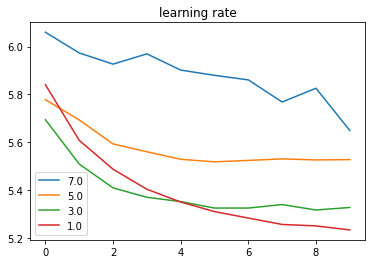

In [27]:
from matplotlib import pyplot as plt

lrList = [7.0, 5.0, 3.0, 1.0]
for lr in lrList:
  lr_list = val_loss_lr_dic[lr]
  plt.plot(lr_list, label=lr)
  plt.title("learning rate")
  plt.legend()


### テストセット上での評価

In [28]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.14 | test ppl   171.20


## TransformerEncoderLayerの層の数チューニング

### 訓練の実行

In [30]:
best_val_loss = float('inf')
epochs = 10
best_model = None

val_loss_lay_dic = {}

layList = [1, 2, 3, 4]
for lay in layList:
  print(f"======lay:{lay}=======")
  model = getModel(nlayers=lay, nhead=2)
  optimizer, scheduler = getOptimizerAndScheduler(1.0)
  val_loss_list = []

  for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    val_loss_list.append(val_loss)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = copy.deepcopy(model)

    scheduler.step()

  val_loss_lay_dic[lay] = val_loss_list

======lay:1=======
| epoch   1 |   200/ 2928 batches | lr 1.00 | ms/batch 13.59 | loss  7.42 | ppl  1670.30
| epoch   1 |   400/ 2928 batches | lr 1.00 | ms/batch 13.31 | loss  6.83 | ppl   924.78
| epoch   1 |   600/ 2928 batches | lr 1.00 | ms/batch 13.36 | loss  6.58 | ppl   720.51
| epoch   1 |   800/ 2928 batches | lr 1.00 | ms/batch 13.45 | loss  6.49 | ppl   658.72
| epoch   1 |  1000/ 2928 batches | lr 1.00 | ms/batch 13.52 | loss  6.38 | ppl   590.56
| epoch   1 |  1200/ 2928 batches | lr 1.00 | ms/batch 13.53 | loss  6.35 | ppl   574.37
| epoch   1 |  1400/ 2928 batches | lr 1.00 | ms/batch 13.54 | loss  6.27 | ppl   529.02
| epoch   1 |  1600/ 2928 batches | lr 1.00 | ms/batch 13.56 | loss  6.26 | ppl   522.78
| epoch   1 |  1800/ 2928 batches | lr 1.00 | ms/batch 13.55 | loss  6.17 | ppl   479.91
| epoch   1 |  2000/ 2928 batches | lr 1.00 | ms/batch 13.54 | loss  6.16 | ppl   474.63
| epoch   1 |  2200/ 2928 batches | lr 1.00 | ms/batch 13.55 | loss  6.04 | ppl   419.72
| 

### 考査
学習率は1.0の前提に、epochesを増えるにつれて、lossも減っています。
同じepochesの場合、３層と４層の差異は小さいです。

一応４層を設定することにします。

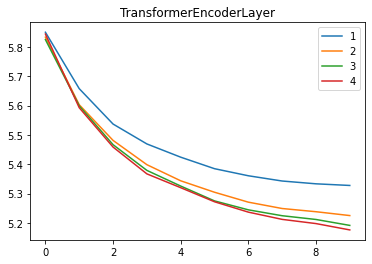

In [31]:
layList = [1, 2, 3, 4]
for lay in layList:
  lay_list = val_loss_lay_dic[lay]
  plt.plot(lay_list, label=lay)
  plt.title("TransformerEncoderLayer")
  plt.legend()

### テストセット上での評価




In [32]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.08 | test ppl   160.09


## MultiheadAttentionのヘッドの数のチューイング

### 訓練の実行

In [33]:
best_val_loss = float('inf')
epochs = 10
best_model = None

val_loss_head_dic = {}

headList = [1, 2, 4, 8]
for head in headList:
  print(f"======head:{head}=======")
  model = getModel(nlayers=4, nhead=head)
  optimizer, scheduler = getOptimizerAndScheduler(1.0)
  val_loss_list = []

  for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    val_loss_list.append(val_loss)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = copy.deepcopy(model)

    scheduler.step()

  val_loss_head_dic[head] = val_loss_list

======head:1=======
| epoch   1 |   200/ 2928 batches | lr 1.00 | ms/batch 19.98 | loss  7.46 | ppl  1740.45
| epoch   1 |   400/ 2928 batches | lr 1.00 | ms/batch 17.84 | loss  6.86 | ppl   953.09
| epoch   1 |   600/ 2928 batches | lr 1.00 | ms/batch 18.31 | loss  6.62 | ppl   747.08
| epoch   1 |   800/ 2928 batches | lr 1.00 | ms/batch 17.92 | loss  6.53 | ppl   686.97
| epoch   1 |  1000/ 2928 batches | lr 1.00 | ms/batch 18.01 | loss  6.42 | ppl   614.70
| epoch   1 |  1200/ 2928 batches | lr 1.00 | ms/batch 18.05 | loss  6.39 | ppl   594.08
| epoch   1 |  1400/ 2928 batches | lr 1.00 | ms/batch 18.04 | loss  6.30 | ppl   543.23
| epoch   1 |  1600/ 2928 batches | lr 1.00 | ms/batch 17.87 | loss  6.28 | ppl   534.47
| epoch   1 |  1800/ 2928 batches | lr 1.00 | ms/batch 17.78 | loss  6.20 | ppl   491.67
| epoch   1 |  2000/ 2928 batches | lr 1.00 | ms/batch 17.68 | loss  6.18 | ppl   480.94
| epoch   1 |  2200/ 2928 batches | lr 1.00 | ms/batch 17.81 | loss  6.05 | ppl   424.30
|

### 考査
学習率は1.0、４層の前提に、epochesを増えるにつれて、lossも減っています。
同じepochesの場合、ヘッダ間の差異は小さいです。

MultiheadAttentionのヘッド数の影響は小さいと思います。

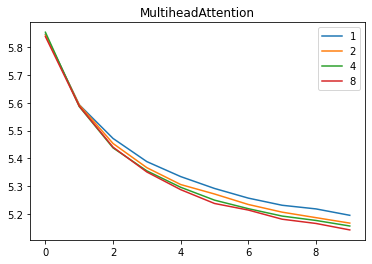

In [34]:
headList = [1, 2, 4, 8]
for head in headList:
  head_list = val_loss_head_dic[head]
  plt.plot(head_list, label=head)
  plt.title("MultiheadAttention")
  plt.legend()

### テストセット上での評価

In [35]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.06 | test ppl   157.62
